# TP 2 : Computer Vision

## Part 3 : motion estimation

In this part of the TP, we are going to look at the following method for estimating motion :

- block matching

First, let us again load some packages and define some helper functions

--2021-12-03 14:42:54--  https://perso.telecom-paristech.fr/anewson/doc/images/afgrunden_1.png
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.22.227, 2a04:8ec0:0:a::89c2:16e3
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.22.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 165703 (162K) [image/png]
Saving to: ‘afgrunden_1.png.1’

afgrunden_1.png.1   100%[===================>] 161.82K   693KB/s    in 0.2s    

2021-12-03 14:42:55 (693 KB/s) - ‘afgrunden_1.png.1’ saved [165703/165703]

--2021-12-03 14:42:55--  https://perso.telecom-paristech.fr/anewson/doc/images/afgrunden_2.png
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.22.227, 2a04:8ec0:0:a::89c2:16e3
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.22.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 165797 (162K) [image/png]
Saving to: ‘afgrunden_2.png.1’


(448, 624)

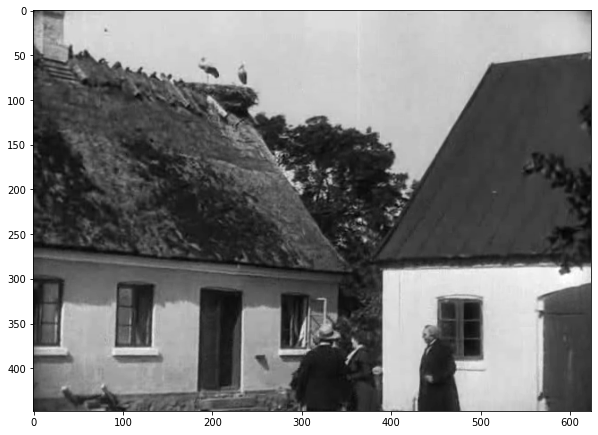

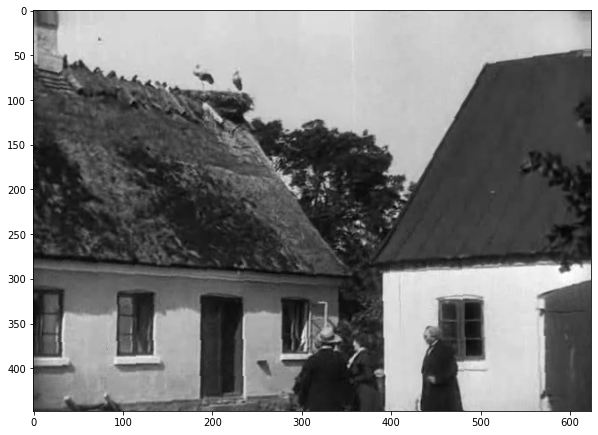

In [2]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np 
import imageio
from skimage import color
from scipy import signal
from scipy.ndimage.morphology import binary_dilation

is_colab = True

def read_image(file_name):
    img_color = imageio.imread(file_name)
    img_gray = color.rgb2gray(img_color)
    return img_gray,img_color
    
def write_image(img_in,file_name_out):
    imageio.imwrite(file_name_out, np.uint8(255.0*img_in))
    
def display_image(img_in):
    plt.figure(figsize=(10, 10))
    if (img_in.ndim == 2):
        plt.imshow(img_in,cmap='gray')
    elif (img_in.ndim == 3):
        # careful, in this case we supppose the pixel values are between 0 and 255
        plt.imshow(np.uint8(img_in))
    else:
        print('Error, unknown number of dimensions in image')
    return

def display_motion(img_1,img_2,key_pts,motion,file_save=''):
    
    motion_x = motion[:,0]
    motion_y = motion[:,1]
    
    img_size = img_1.shape
    
    head_width=2.0
    head_length=3.0

    fig = plt.figure()
    plt.figure(figsize=(10, 10))
    ax = plt.imshow(img_1,cmap='gray')

    print(key_pts.shape[0])
    for i in range(0,key_pts.shape[0]):
        x = key_pts[i,0]
        y = key_pts[i,1]
        plt.arrow(x,y, motion_x[i],motion_y[i] , color='r',
            head_width=head_width, head_length=head_length,)
    plt.gca().set_axis_off()
    fig.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(mpl.ticker.NullLocator())
    plt.gca().yaxis.set_major_locator(mpl.ticker.NullLocator())

    if (file_save != ''):
        plt.savefig(file_save, bbox_inches = 'tight', pad_inches = 0)

file_dir = 'images/'
file_name_1 = 'afgrunden_1'
file_name_2 = 'afgrunden_2'
file_ext = '.png'

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/afgrunden_1.png"
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/afgrunden_2.png"
  img_1,_ = read_image(file_name_1+file_ext)
  img_2,_ = read_image(file_name_2+file_ext)
else:
  img_1,_ = read_image(file_dir+file_name_1+file_ext)
  img_2,_ = read_image(file_dir+file_name_2+file_ext)

display_image(img_1)
display_image(img_2)
img_size = img_1.shape
img_size

__Question 3.1__ What sort of motion do you think is there between img_1 and img_2 ? You may want to flip between one image and another in an external viewer.

---
**Answer 3.1 :** 
It seems that there is a small rotation between both images.

---

## Block matching

Block matching is a very intuitive algorithm for motion estimation. We choose a patch size, and for each patch $\Psi_p$ in the first frame, we look for the patch $\Psi_q$ which is the most similar, in a certain region around the original position. The motion $(u,v)$ is then defined as $(u,v) = q-p$, such that : 

$
\begin{cases}
q_x = p_x+u\\
q_y = p_y+v
\end{cases}
$

The ''similarity'' between two patches is the sum of squared differences (SSD) :

$d(\Psi_p,\Psi_q) = \sum_{i \in \mathcal{N}} \left( I(p+i) - I(q+i) \right)^2,$

where $\mathcal{N}$ is the patch neighbourhood (a square).

We are going to be implementing block matching in a function called ``block_matching``. However, this can take a lot of time, so we only carry it out on a subset of the pixels, which we will call ``key_pts``. This will be a matrix of size $(N,2)$, where $N$ is the number of keypoints, and where each line has the following format :

- $[x,y]$

Create this function now, with the following parameters :

- block_size = 7 (the patch size)
- search_size = 15 (the maximum distance we search for the same patch in)

You will have to deal with border conditions. There are two ways of doing this :

- not allowing the patch search to go near to the borders (no closer than half the patch size)
- making partial patch comparisons

You can choose either method. The first is slightly easier to implement, but potentially incorrect near the borders. The second is more correct, but you have to make sure to make partial patch comparisons.

Make sure you do __not__ carry out the patch distance with a loop (which would not be very optimal). You can first create the patch neighbourhood with

- ``np.meshgrid``

and then take the SSD of the two patches.


In [129]:
def ssd(patch1, patch2):
  return ((patch1 - patch2)**2).sum()

In [130]:
def get_patch(img, key_pt, block_size=7):
  n, m = img.shape[0], img.shape[1]
  x, y = key_pt[0], key_pt[1]
  t = block_size//2
  if (x-t>0) and (x+t<n) and (y-t>0) and (y+t<m):
    return img[x-t:x+t, y-t:y+t]
  else:
    return np.array([])

In [137]:
research_size = 15
T = research_size // 2

In [151]:
def block_matching(img_1,img_2,key_pts):
  n_pts = len(key_pts)
  motion = np.zeros((n_pts,2))
  for num, key_pt in enumerate(key_pts):
    min_ssd = 100
    deplacement = [0, 0]
    patch1 = get_patch(img_1, key_pt, block_size=7)
    for i in range(-T,T+1):
      for j in range(-T,T+1):
        key_pt2 = key_pt + np.array([i,j])
        patch2 = get_patch(img_2, key_pt2, block_size=7)
        if patch1.shape == patch2.shape:
          new_ssd = ssd(patch1, patch2)
          if new_ssd < min_ssd:
            # print(i, j)
            min_ssd = new_ssd
            deplacement = [i, j]
    motion[num] = deplacement
  return motion

We now draw some random keypoints.

In [152]:
n_pts = 80
key_pts = np.zeros((n_pts,2)).astype(int)
# a random seed, if you want repeatability
np.random.seed(10)

pixel_list = np.asarray(range(0,img_size[0]*img_size[1]))
np.random.shuffle(pixel_list)
key_pts = np.zeros((n_pts,2)).astype(int)
key_pts[:,1],key_pts[:,0] = np.unravel_index(pixel_list[0:n_pts],img_size)

In [153]:
key_pts[:,0].max()

621

Carry out the block matching and display the result with the ``display_motion`` function.

In [154]:
motion = block_matching(img_1,img_2,key_pts)

80
80


<Figure size 432x288 with 0 Axes>

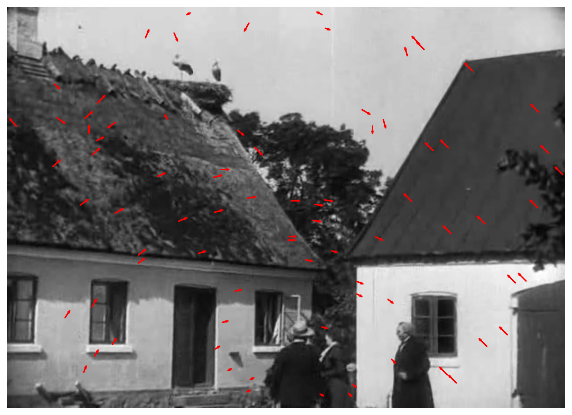

<Figure size 432x288 with 0 Axes>

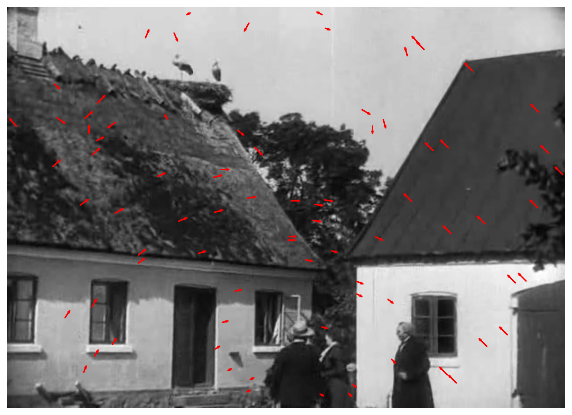

In [156]:
display_motion(img_1,img_2,key_pts,motion)
display_motion(img_1,img_2,key_pts,motion,file_name_1+'_motion_out.png')

__Question 3.2__ Does this look reasonable to you ? In what regions do you think the estimation might fail ? Does this visualisation confirm your hypothesis concerning the type of motion ?

---

***Answer 3.2 :***

It confirms my first impression : there is a rotation. It might fails in homogeneous regions. 

---

__Question 3.3__ In this exercise, we used random points. What methods seen in the lesson could you use to choose better points. Explain why such points are better suited for the block matching algorithm.

---

***Answer 3.3 :*** We could use corner points because they are not part from a homogeneous region.

---

__Question 3.4__ In this work, we have considered that each pixel/patch has its own, separate, local, motion. This is not the best model for the motion observed in these two images.

What is a better motion model to use here? Why is this model better? Describe an algorithm to calculate such a motion.

---

***Answer 3.4 :*** To regularise the motion field we can use a
variational framework and the algorithm optical flow. This algorithm consists in minimizing the Horn-schunck variational formulation for optical flow with by solving the the associated Euler-Lagrange equations

---